<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch01_CH02_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification


In [1]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


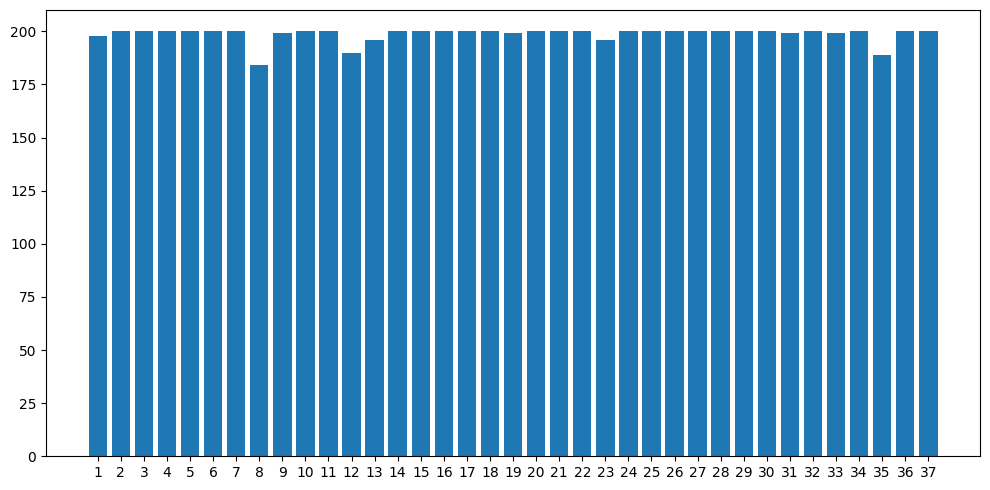

In [2]:
# Image CLASS-ID SPECIES BREED ID
# ID: 1:37 Class ids
# SPECIES: 1:Cat 2:Dog
# BREED ID: 1-25:Cat 1:12:Dog
# All images with 1st letter as captial are cat images while
# images with small first letter are dog images.

csv_path = '/content/drive/MyDrive/data/kfolds.csv'

df = pd.read_csv(csv_path)
np.unique(df['id'])

value_counts = df['id'].value_counts().sort_index()
plt.figure(figsize = (10,5))
plt.bar(range(len(value_counts)), value_counts.values, align = 'center')
plt.xticks(range(len(value_counts)), value_counts.index.values )

plt.tight_layout()
plt.show()

In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

def get_model(input_shape):
  inputs = keras.Input(input_shape)
  base_model = EfficientNetB0(
      input_shape = input_shape,
      weights = 'imagenet',
      include_top = False,   # True : 분류까지 다 가져옴, False : 피처벡터 추출까지만 가져옴
      pooling = 'avg',
  )

  x = base_model(inputs)
  outputs = layers.Dense(37, activation= 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model

input_shape =(256, 256, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy', # label을 one-hot인코딩 하지 않아도 학습 가능
    metrics = 'accuracy'
)

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 37)                47397     
                                                                 
Total params: 4096968 (15.63 MB)
Trainable params: 4054945 (15.47 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [4]:
import albumentations as A
import cv2

class Augmentation:
  def __init__(self, size, mode ='train'):
    if mode =='train':
      # Declare an augmentation pipeline
      self.transform = A.Compose([
          A.HorizontalFlip(p=0.5), # 좌우반전, p(적용할 확률)
          A.ShiftScaleRotate(
              p = 0.5,
              shift_limit = 0.05,
              scale_limit = 0.05,
              rotate_limit = 15,
          ), # 이동%, 확대축소%, 회전각도 제약걸기
          A.CoarseDropout(
              p = 0.5,
              max_holes =8,
              max_height = int(0.1 * size),
              max_width = int(0.1 * size),
          ),
          A.RandomBrightnessContrast(p=0.2),
      ])

  def __call__(self, **kwargs):
    if self.transform:
      aumented = self.transform(**kwargs)
      img = aumented['image']
      return img


In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        batch_size,
        csv_path,
        fold,
        image_size,
        mode ='train',
        shuffle = True):

        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]


        ### Remove invalid files
        ### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)

        self.on_epoch_end()


    def __len__(self):
        return math.ceil(len(self.df)/self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1)* self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x =[]
        batch_y =[]

        for _, r in data.iterrows():
            file_name = r['filename']

            image = cv2.imread(f'/content/drive/MyDrive/data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # input image resize (배치로 묶기위해)
            image = cv2.resize(image, (self.image_size, self.image_size))

            if self.mode == 'train':
              image = image.astype('uint8')
              image = self.transform(image = image)

            # rescaling
            image = image /255.

            # id - 1을 label로 사용
            label = int(r['id']) -1

            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y



    def on_epoch_end(self): # callback function
        if self.shuffle:
            self.df = self.df.sample(frac =1).reset_index(drop=True)


In [6]:
csv_path = '/content/drive/MyDrive/data/kfolds.csv'
train_generator = DataGenerator(
    batch_size = 64,
    csv_path =csv_path,
    fold = 1,
    image_size = 256,
    mode ='train',
    shuffle = True
)

val_generator = DataGenerator(
    batch_size = 64,
    csv_path =csv_path,
    fold = 1,
    image_size = 256,
    mode ='val',
    shuffle = True
)

In [7]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
92/92 [==============================] - 1633s 17s/step - loss: 2.7164 - accuracy: 0.3870 - val_loss: 3.6202 - val_accuracy: 0.0245
Epoch 2/10
92/92 [==============================] - 94s 1s/step - loss: 0.9907 - accuracy: 0.7896 - val_loss: 3.6297 - val_accuracy: 0.0252
Epoch 3/10
92/92 [==============================] - 102s 1s/step - loss: 0.4892 - accuracy: 0.8796 - val_loss: 3.6356 - val_accuracy: 0.0204
Epoch 4/10
92/92 [==============================] - 98s 1s/step - loss: 0.3407 - accuracy: 0.9098 - val_loss: 3.4555 - val_accuracy: 0.0626
Epoch 5/10
92/92 [==============================] - 98s 1s/step - loss: 0.2459 - accuracy: 0.9372 - val_loss: 3.5939 - val_accuracy: 0.0313
Epoch 6/10
92/92 [==============================] - 93s 1s/step - loss: 0.1889 - accuracy: 0.9518 - val_loss: 3.2778 - val_accuracy: 0.1110
Epoch 7/10
92/92 [==============================] - 96s 1s/step - loss: 0.1505 - accuracy: 0.9614 - val_loss: 1.9661 - val_accuracy: 0.4234
Epoch 8/10
92/92

<function matplotlib.pyplot.show(close=None, block=None)>

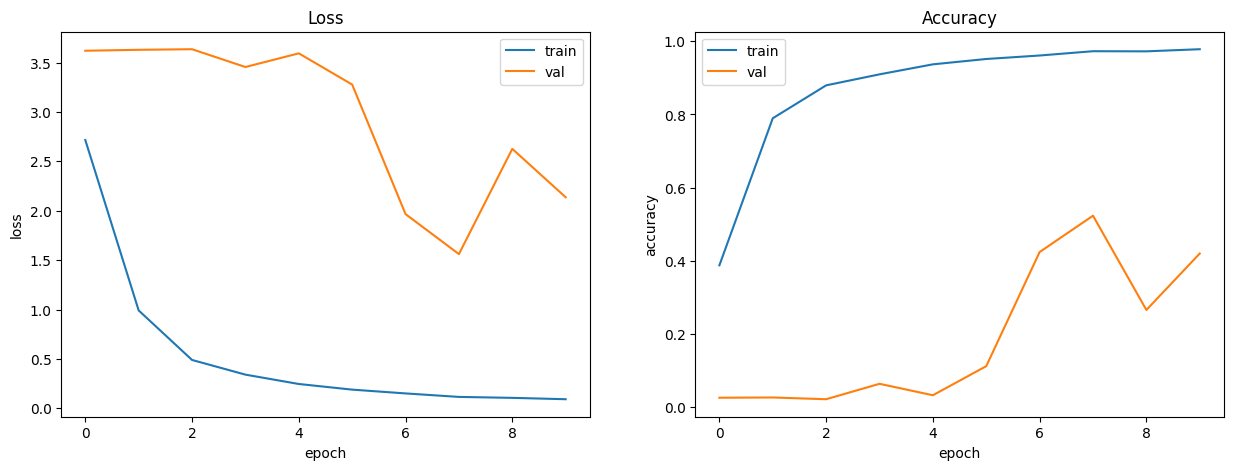

In [8]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label ='train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label ='train')
plt.plot(history['val_accuracy'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show
